[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    #os.environ.pop(var, None)  # Removes var if it exists, does nothing otherwise
    
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ.pop("LANGCHAIN_TRACING_V2", None) 
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ.pop("LANGCHAIN_PROJECT", None) 
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ.pop("LANGCHAIN_ENDPOINT", None) 
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.callbacks.tracers.langchain import wait_for_all_tracers
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
#llm = ChatOpenAI(model="gpt-4o")
try:
    response = llm.invoke(messages)
    print(response)
finally:
    wait_for_all_tracers()

content='There are many fascinating ocean mammals besides whales that you might want to explore. Here are a few:\n\n1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are closely related to whales and are found in many oceans worldwide.\n\n2. **Porpoises**: Similar to dolphins, porpoises are smaller and have different facial features. They are generally shyer than dolphins.\n\n3. **Seals**: These are semi-aquatic marine mammals that spend a lot of time both in the water and on land. There are various species, including harbor seals and elephant seals.\n\n4. **Sea Lions**: Often confused with seals, sea lions are more agile on land due to their rotating hind flippers and external ear flaps.\n\n5. **Walruses**: Known for their distinctive tusks, walruses are large marine mammals that live in the Arctic and sub-Arctic regions.\n\n6. **Manatees**: Sometimes called sea cows, manatees are gentle, slow-moving herbivores found in warm coastal waters and rivers.\n\n7. 

We can run our chat model in a simple graph with `MessagesState`.

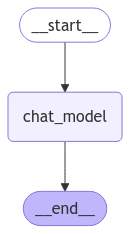

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several other fascinating ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent and social creatures, dolphins are known for their playful behavior and complex communication systems. There are several species, including the bottlenose dolphin and the orca, or killer whale, which is actually the largest member of the dolphin family.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different dental and facial structures. They tend to be shyer than dolphins and are found in various oceanic regions.

3. **Seals**: These pinnipeds 

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

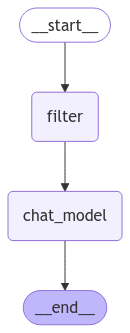

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in many oceans and rivers worldwide. Species include the bottlenose dolphin, common dolphin, and the orca (also known as the killer whale, though it’s technically a dolphin).

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial features, porpoises are another interesting group of marine mammals.

3. **Seals**: These are semi-aquatic marine mammals with species such as the harbor seal and the grey seal

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

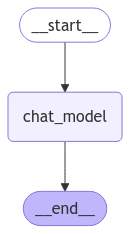

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in many oceans and rivers worldwide. Species include the bottlenose dolphin, common dolphin, and the orca (also known as the killer whale, though it’s technically a dolphin).

2. **Porpoises**: Similar to dolphins but generally smaller and with

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

In addition to whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: Known for their intelligence and playful behavior, dolphins are found in many oceans and rivers worldwide. Species include the bottlenose dolphin, common dolphin, and the orca (also known as the killer whale, though it’s technically a dolphin).

2. **Porpoises**: Similar to dolphins but generally smaller and with

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

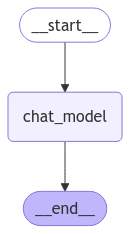

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-3.5-turbo-0125"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [19]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-3.5-turbo-0125"),
            allow_partial=True
        )

[AIMessage(content='\nNarwhals are often called the "unicorns of the sea" due to their unique tusks, and they continue to capture the imagination of people around the world with their mysterious and elusive nature.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 466, 'prompt_tokens': 17, 'total_tokens': 483, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-1178a275-dea4-4aeb-98be-75119e9d1dea-0', usage_metadata={'input_tokens': 17, 'output_tokens': 466, 'total_tokens': 483, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response

In [20]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r